In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as tr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

In [2]:
def load_csvs_to_dfs(filenames):
    dataframes = []
    for name in filenames:
        file_path = f'../data/{name}.csv'
        try:
            df = pd.read_csv(file_path)
            dataframes.append(df)
            print(f'Loaded {file_path} into DataFrame: {name}')
        except FileNotFoundError:
            print(f'File {file_path} not found.')
    return dataframes

csvs = [
        'cesd_total', 
        'gad_total',
        'inq_perceivedburden',
        'inq_thwartedbelong',
        'upps_total']
dataframes = load_csvs_to_dfs(csvs)

Loaded ../data/cesd_total.csv into DataFrame: cesd_total
Loaded ../data/gad_total.csv into DataFrame: gad_total
Loaded ../data/inq_perceivedburden.csv into DataFrame: inq_perceivedburden
Loaded ../data/inq_thwartedbelong.csv into DataFrame: inq_thwartedbelong
Loaded ../data/upps_total.csv into DataFrame: upps_total


In [3]:
def plot_outcome(df: pd.DataFrame):
    # Extract the last column
    last_column_name = df.columns[-1]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.hist(df[last_column_name], bins=50)
    plt.title(f'Histogram of {last_column_name}')
    plt.ylabel(last_column_name)
    plt.grid(True)

    plt.savefig(f'../plots/hist_{last_column_name}.png')

In [4]:
def plot_correlations(df: pd.DataFrame):
    last_column_name = df.columns[-1]
    sns.clustermap(df.corr(), cmap='viridis')
    plt.savefig(f'../plots/corr_{last_column_name}.png')

In [10]:
def create_splits(df:pd.DataFrame):
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.15, 
        random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, 
        y_train,
        test_size=X_test.shape[0] / X_train.shape[0],  
        random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
def identify_variable_types(data):
    continuous_vars = []
    dummy_vars = []

    num_columns = data.shape[1]
    
    for i in range(num_columns):
        unique_values = np.unique(data[:, i])
        if len(unique_values) == 2 and np.array_equal(unique_values, [0, 1]):
            dummy_vars.append(i)
        else:
            continuous_vars.append(i)
    
    return continuous_vars, dummy_vars

In [12]:
def transform_X(split):

    continuous_cols, dummy_cols = identify_variable_types(split)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), continuous_cols),
            ('dummy', 'passthrough', dummy_cols)  # Leave dummy variables unchanged or use StandardScaler() if needed
        ]
    )
    split = preprocessor.fit_transform(split)

    return split

In [15]:
def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop

In [16]:
def evaluate(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    model_performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [13]:
def loop_through_dfs(list_of_dfs):
    for idx, df in enumerate(list_of_dfs):
        
        # plot outcome variable
        plot_outcome(df)

        # plot correlations
        plot_correlations(df)

        # create splits
        X_train, X_val, X_test, y_train, y_val, y_test = create_splits(df)

        # transform X
        X_train = transform_X(X_train)
        X_val = transform_X(X_val)
        X_test = transform_X(X_test)
        
        

/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ucloud/.local/

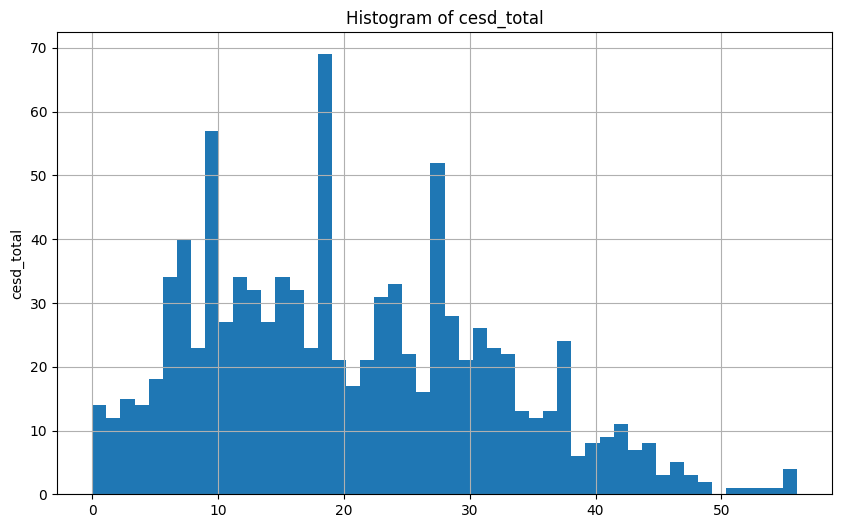

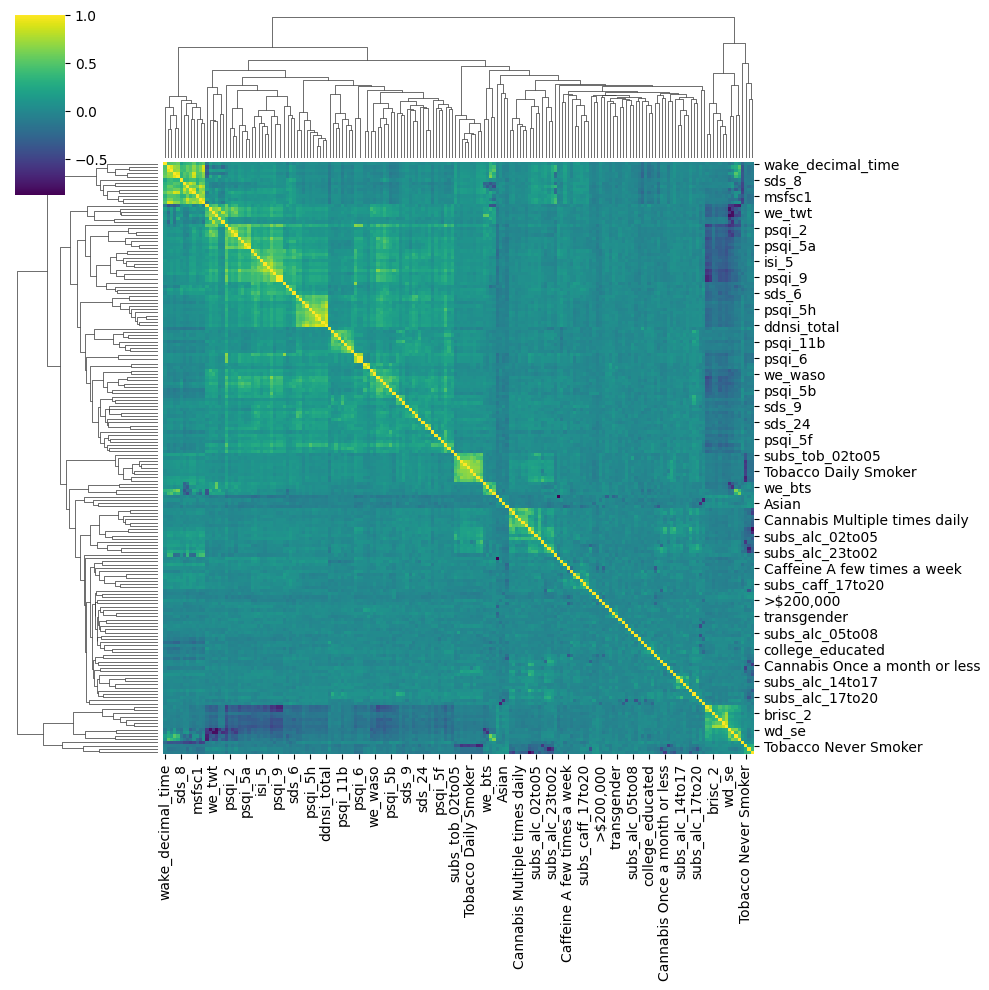

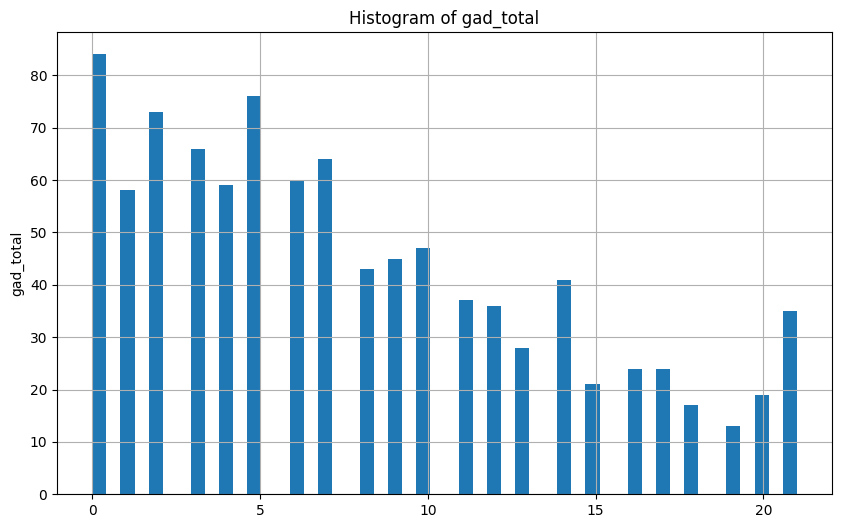

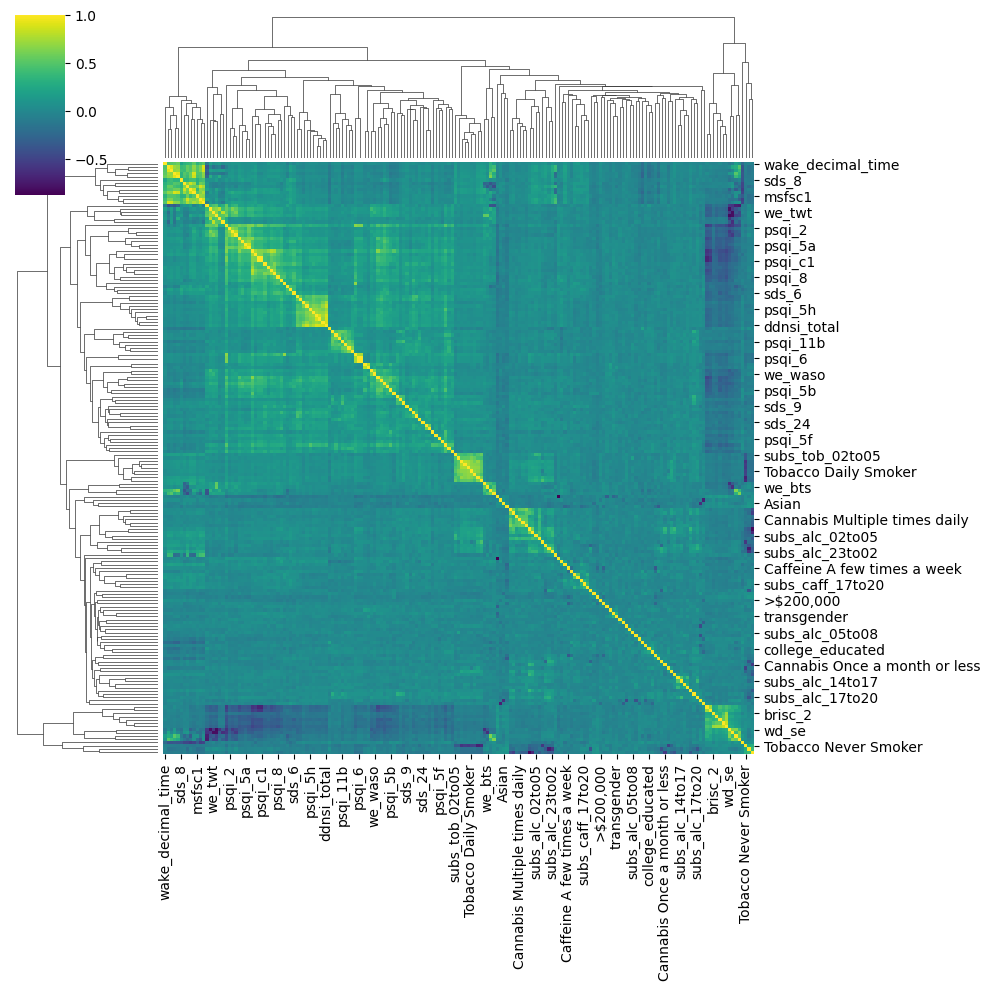

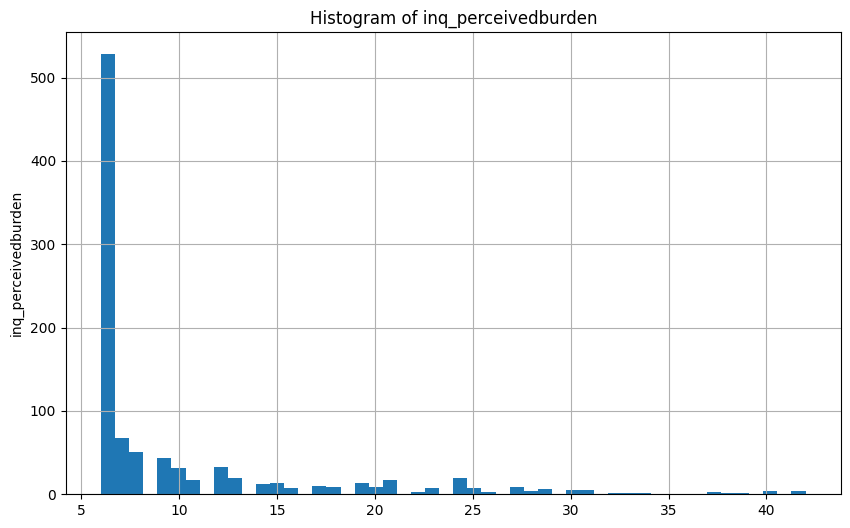

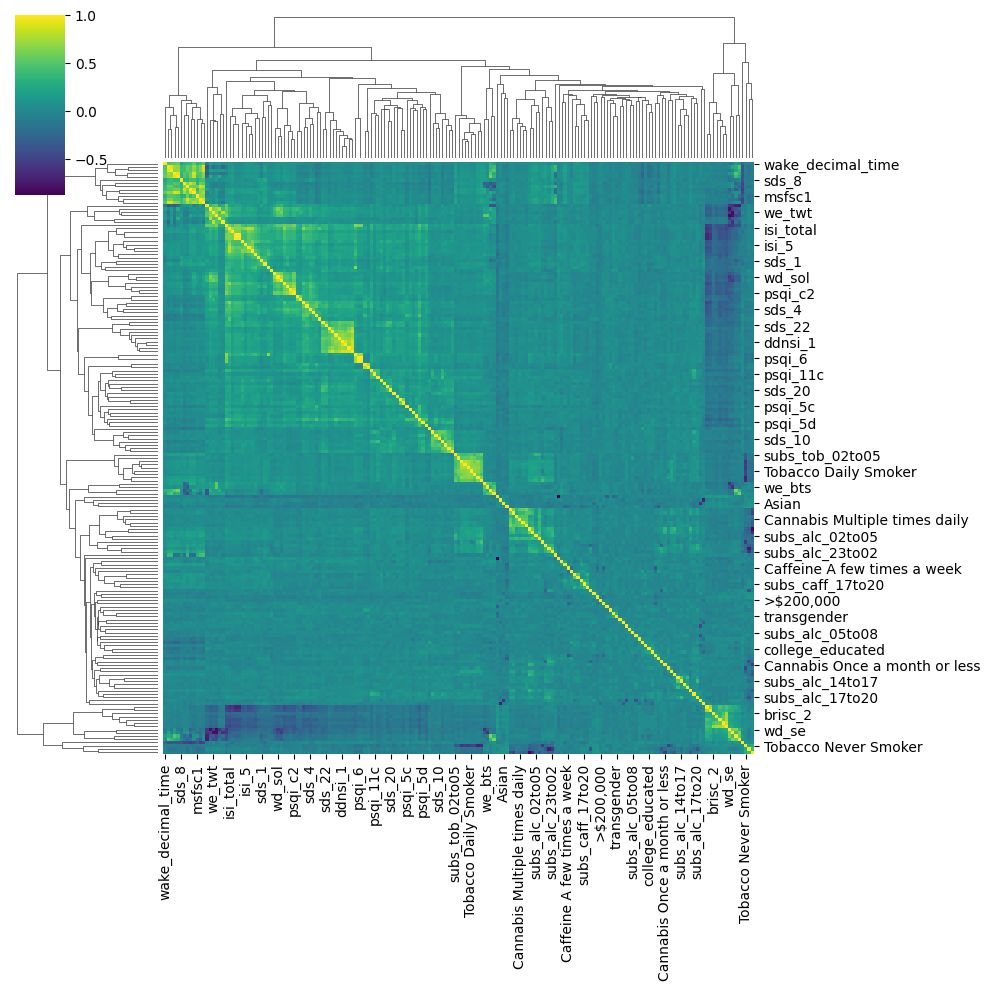

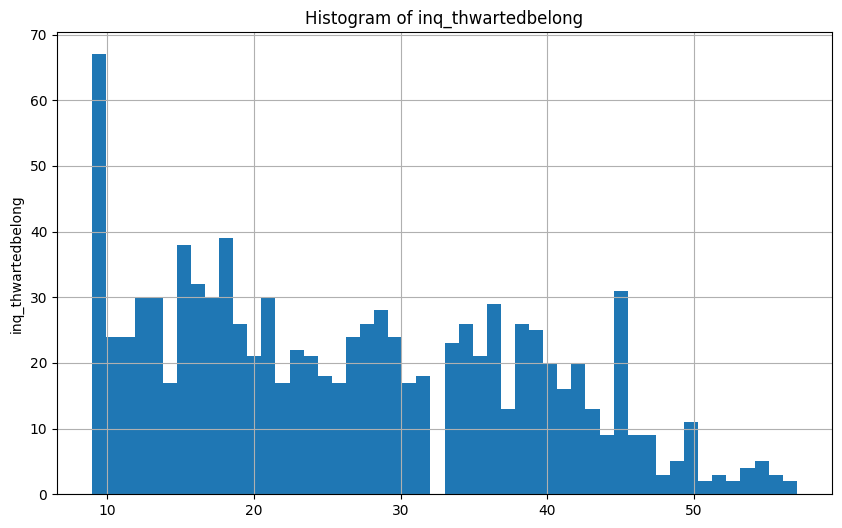

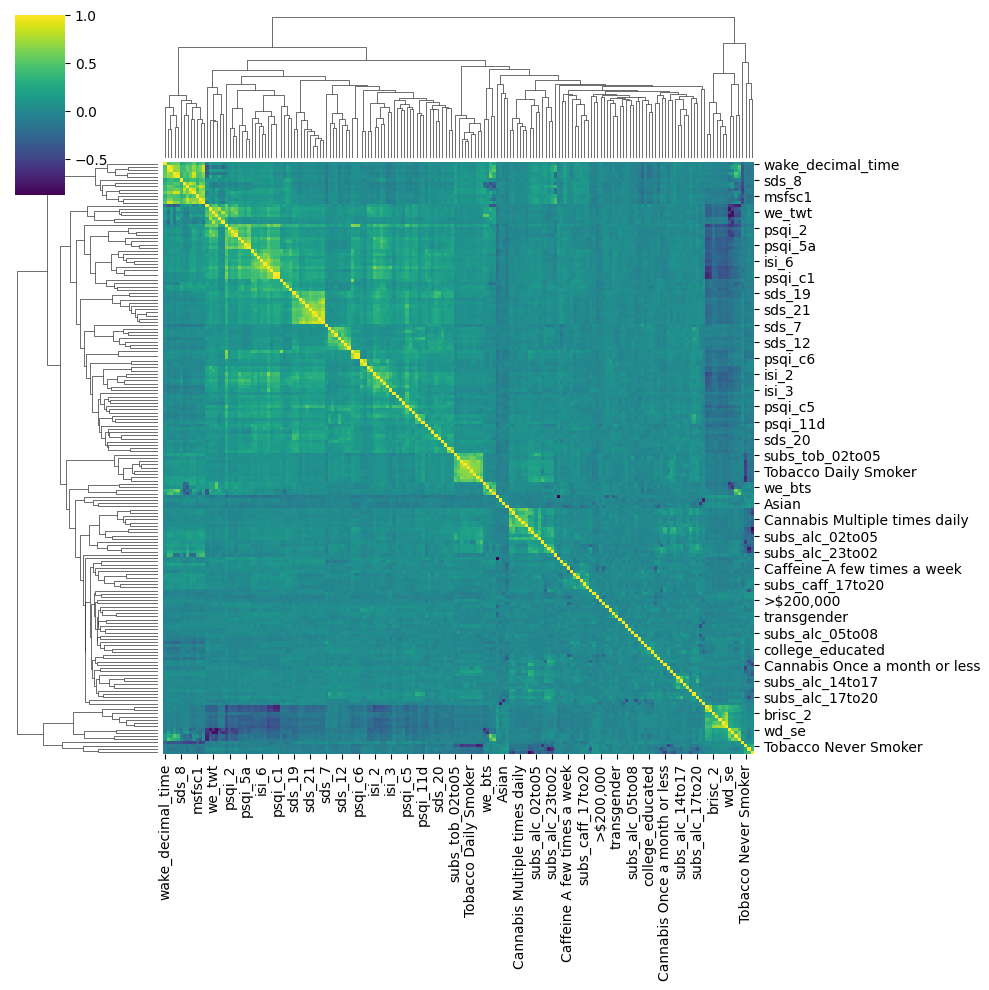

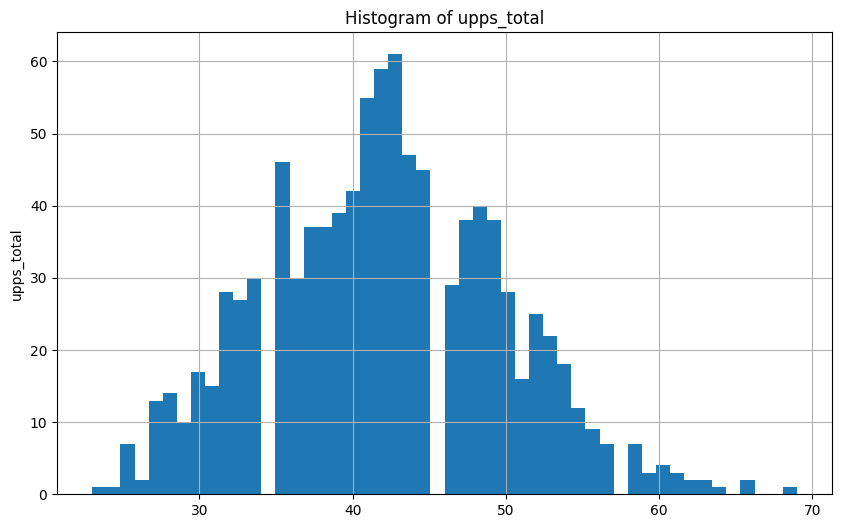

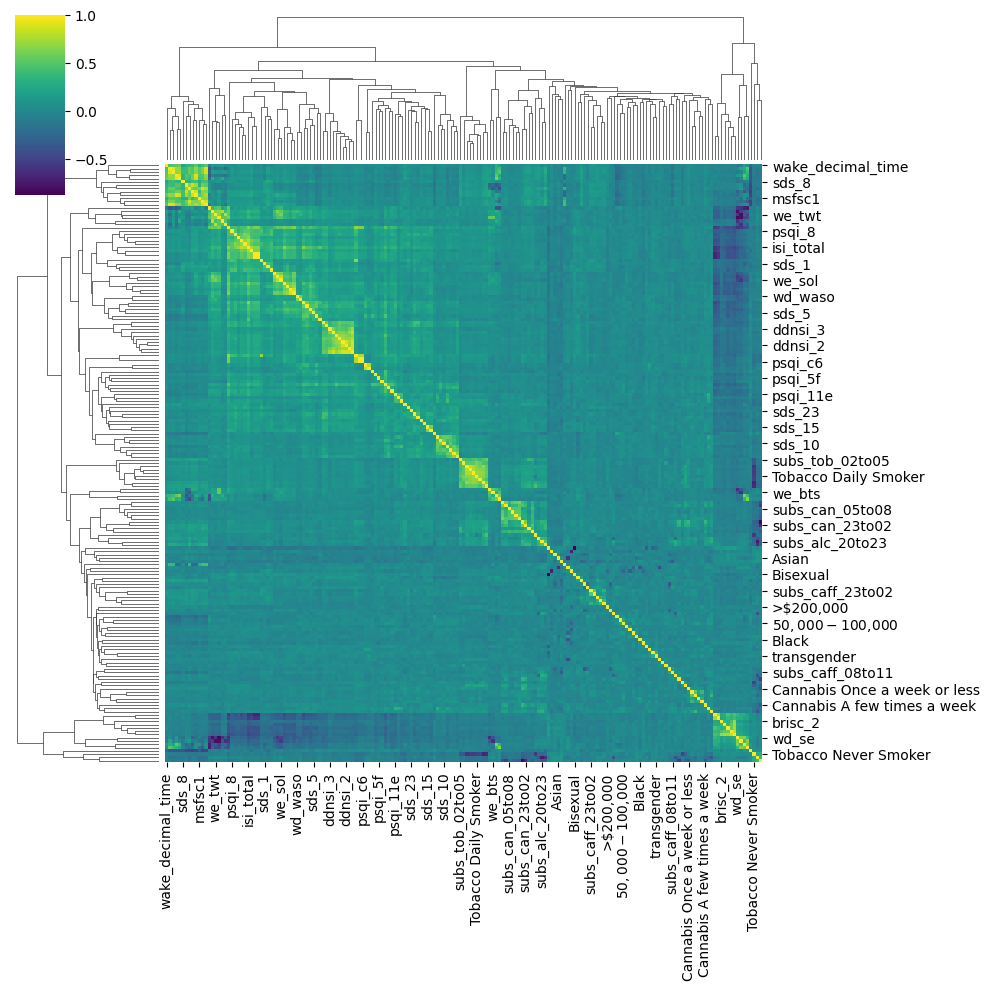

In [14]:
loop_through_dfs(dataframes)